# Sprint 10 DeepNeuralNetwork
### ディープニューラルネットワーク

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


## データ準備

In [2]:
# 読み込み
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 二次元の画像データ→一次元の行データ
# (60000, 28, 28) → (60000, 784)
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 正規化(0~1の間にデータを変換)
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255

# 分割(訓練データ・評価データ
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

# one-hotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_val[:, np.newaxis])

## 問題1 全結合層のクラス化

In [3]:
class FC:
    """ノード数n_nodes1からn_nodes2への全結合層"""
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        """
        Parameters
        ----------
        n_nodes1 : int
            前の層のニューロン数
        n_nodes2 : int
            当該層のニューロン数
        initializer : 初期化したインスタンス
        optimizer : 勾配更新手法(インスタンス)
        """

        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2

        # 初期化インスタンスのメソッドを使い
        # 重みとバイアスを初期化
        self.W = initializer.W(self, self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self, self.n_nodes2)

        # 最適化インスタンス
        self.optimizer = optimizer
        
        # 勾配更新の際に使用（AdaGradのみ）
        # self.HW = 0
        # self.HB = 0
        
    def forward(self, x):
        """順伝播
        フォワードプロバゲーション
        Parameters
        ----------
        x : 順伝播されてきた値
        """
        # 逆伝播時に渡すためself化
        self.Z = x

        # fowardの計算（活性化関数前まで）
        self.A = x @ self.W + self.B

        return self.A
    
    def backward(self, dA):
        """逆伝播
        Parameters
        ----------
        dA : 前の層の出力値
             活性化関数の逆伝播の値が入ってくる
        """
        # 重みの勾配
        self.dW = self.Z.T @ dA

        # バイアスの勾配
        self.dB = np.sum(dA, axis=0)

        # 逆伝播で次の層へ渡す（返す）値
        self.dZ = dA @ self.dW.T

        # 重み更新(DIVER参照)
        self = self.optimizer.update(self)#FCクラスのインスタンスが引数

        return self.dZ

## 問題2 初期化方法のクラス化

In [4]:
class SimpleInitializer:
    """各種重みの初期化"""
    def __init__(self, sigma):
        """
        Parameters
        ----------
        sigma : 重みの初期化の際のガウス分布の標準偏差
        """
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        Parameters
        ----------
        n_nodes1 : 前の層のニューロン数
        n_nodes2 : 当該層のニューロン数
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        Parameters
        ----------
        n_nodes2 : 当該層のニューロン数
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

## 問題3 最適化手法のクラス化

In [5]:
class SGD:
    """勾配更新手法"""
    def __init__(self, lr):
        """
        Parameters
        ----------
        lr : 学習率
        """
        self.lr = lr
        
    def update(self, layer):
        """更新
        Parameters
        ----------
        layer : FCクラスのインスタンス
        """
        # len(Z)でわる？
        layer.W -= self.lr * layer.W
        layer.B -= self.lr * layer.B
        return layer

## 問題4 活性化関数のクラス

In [6]:
class Sigmoid:
    """シグモイド関数"""
    def forward(self, A):

        self.A = A
        Z = 1 / (1 + np.exp(-self.A))
        return Z
    def backward(self, dZ):

        dA = dZ * ((1 / (1 + np.exp(-self.A))) - (1 / (1 + np.exp(-self.A)))**2)
        return dA

# class Sigmoid:

#     def forword(self, Z):
#         return 1 / (1+np.exp(-self.Z))

#     def backword(self, Z):
#         return self.forword(self.Z)*(1-forword(self.Z))
    

In [7]:
class Tanh:
    """tanh関数"""
    def forward(self, A):
        self.A = A
        Z = np.tanh(self.A)
        return Z
    
    def backward(self, dZ):
        dA = dZ * (1 - np.tanh(self.A)**2)
        return dA

In [8]:
class Softmax:
    """Softmax関数"""
    def forward(self, A): 
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z
        
    def backward(self, Z, y):
        # 逆伝播の値
        dA = Z - y
        # 損失
        loss = - np.sum(y * np.log(Z)) / len(y)
        return dA, loss

## 問題5 ReLUクラスの作成

In [9]:
class ReLU:
    """ReLU関数"""
    # 一番おすすめNN
    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z
    
    def backward(self, dZ):
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA

## 問題6 重みの初期値

In [10]:
# `SimpleInitializer`同じ用途だが、初期化方法が異なる
class XavierInitializer:
    #Xavierの初期化
    def __init__(self, sigma):
        # SimpleInitializerではsigmaを使うがこのクラスでは使わない
        # 初期化クラスによっては使う引数なので受け取ってはいる
        _ = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        Parameters
        ----------
        n_nodes1 : 前の層のニューロン数
        n_nodes2 : 当該層のニューロン数
        """
        self.sigma = 1 / np.sqrt(self.n_nodes)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
        
    def B(self, n_nodes2):
        """
        Parameters
        ----------
        n_nodes2 : 当該層のニューロン数
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [11]:
class HeInitializer:
    #Heの初期化#
    def __init__(self, sigma):
        # SimpleInitializerではsigmaを使うがこのクラスでは使わない
        # 初期化クラスによっては使う引数なので受け取ってはいる
        _ = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        Parameters
        ----------
        n_nodes1 : 前の層のニューロン数
        n_nodes2 : 当該層のニューロン数
        """
        self.sigma = np.sqrt(2/self.n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        Parameters
        ----------
        n_nodes2 : 当該層のニューロン数
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

## 問題7 最適化手法

In [12]:
class AdaGrad:
    """最適化手法（AdaGrad）"""
    def __init__(self, lr):
        """コンストラクタ
        Parameters
        ----------
        lr : 学習率
        """
        self.lr = lr 
    
    def update(self, layer):
        """コンストラクタ
        Parameters
        ----------
        layer : layerインスタンス
        """
        layer.HW += layer.dW * layer.dW
        layer.HB += layer.dB * layer.dB
        delta = 1e-7 # 0割エラー防止のため
        
        ### サンプルコード要確認！数式間違い
        layer.W -= self.lr * layer.dW / (layer.HW) / len(layer.Z)
        layer.B -= self.lr * layer.dB / (layer.HB) / len(layer.Z)
        return layer

## 問題8 クラスの完成

In [13]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        """
        Parameters
        ----------
        X : 説明変数（画像の1次元データ）
        y : 目的変数（ラベル）
        batch_size : 必要なミニバッチのデータ数
        seed : ランダムシード固定
        """
        # ランダムシードの固定（学習ごとに同じ生成順）
        np.random.seed(seed)
        # バッチ数のメンバ変数
        self.batch_size = batch_size
        # データ全体の長さ分のインデックスをランダムに並べ替え
        # np.random.permutation:配列をランダムに並べ替え
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        # 並べ替えたインデックスと同じ順番で説明変数と目的変数を並べ替え
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        # データ数をバッチ数で割って、何回呼び出せば、全データを学習したことになるかの判定
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop
    
    def __iter__(self):
        # 何回目の呼び出しか
        self._counter = 0
        return self

    def __next__(self):
        # 全データを学習すればストップ
        if self._counter >= self._stop:
            raise StopIteration()
        # 並び変えた_X,_yの何番目のインデックスを採用するか
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        # returnする前にカウンタに+1しておく
        self._counter += 1
        # 説明変数と目的変数を返す
        return self._X[p0:p1], self._y[p0:p1]

In [14]:
class ScratchDeepNeuralNetrowkClassifier():

    def __init__(self,batch_size=20,n_features=784,n_nodes1 =400,n_nodes2 = 200,n_output =10,lr =0.005,epoch=10,sigma=0.02,optimizer=SGD, initializer=HeInitializer,activater=ReLU,output_activater=Softmax,verbose=True):

        self.batch_size = batch_size#バッチサイズ（default:20)
        self.n_features = n_features#説明変数の数（default:784)
        self.n_nodes1 = n_nodes1#前の層のノード数（default:400)  
        self.n_nodes2 = n_nodes2#当該層のノード数（default:200) 
        self.n_output = n_output#出力層のノード数（default:10)
        self.lr = lr#学習率（default:0.005)
        self.epoch = epoch#学習回数（default:10)
        self.optimizer = optimizer#最適化手法（default:SGD) 
        self.sigma = sigma#初期化時のパラメータ（default:0.02)
        self.initializer = initializer#初期化方法（default:HeInitializer）
        self.activater = activater#活性化関数（default:ReLU）
        self.output_activater = output_activater#出力層の活性化関数（default:Softmax） 
        self.verbose = verbose#計算過程の出力（default:True)
    
        # lossの記録用配列
        self.loss_train = [] 
        self.loss_val = [] 

    def fit(self, x, y, x_val=None, y_val=None):
        """
        Parameters
        ----------
        x : 訓練データの説明変数
        y : 訓練データの目的変数
        x_val : 評価データの説明変数
        y_val : 評価データの目的変数
        """
        # 最適化手法の初期化
        optimizer = self.optimizer(self.lr)
        # 各層の初期化
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer, optimizer)
        self.activation1 = self.activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer, optimizer)
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer, optimizer)
        self.activation3 = self.output_activater()
        
        # 学習回数分ループ
        for i in range(self.epoch):
            # ミニバッチイテレータ生成
            get_mini_batch = GetMiniBatch(x, y, batch_size=self.batch_size, seed=i)
            # ミニバッチイテレータループ
            for mini_x, mini_y in get_mini_batch:
                ## 順伝播(フォワード)
                # 1層目
                A1 = self.FC1.forward(x)
                Z1 = self.activation1.forward(A1)
                # 2層目
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                # 3層目
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                ## 逆伝播（バック）
                dA3, loss = self.output_activater().backward(Z3, y)
                dZ2 = self.FC2.backward(dA3)
                dA2 = self.activation1.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) 
                
            # 過程出力
            if self.verbose:
                ## 順伝播（フォワード）
                # 1層目
                A1 = self.FC1.forward(x)
                Z1 = self.activation1.forward(A1)
                # 2層目
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                # 3層目
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)      
                # 損失計算と記録
                loss = self.activation3.backward(Z3, y)[1]
                self.loss_train.append(loss)
                print('epoch:%d train_loss:%f'%(i,loss))

                # 評価データ見る
                if x_val is not None:
                    ## 順伝播
                    # 1層目
                    A1 = self.FC1.forward(x_val)
                    Z1 = self.activation1.forward(A1)
                    # 2層目
                    A2 = self.FC2.forward(Z1)
                    Z2 = self.activation2.forward(A2)
                    # 3層目
                    A3 = self.FC3.forward(Z2)
                    Z3 = self.activation3.forward(A3)
                    # 損失計算と記録
                    self.loss_val.append(self.activation3.backward(Z3, y_val)[1])
    
    def predict(self, x):
        """予測
        Parameters
        ----------
        x : 入力配列
        """
        ## 順伝播（フォワード）
        # 1層目
        A1 = self.FC1.forward(x)
        Z1 = self.activation1.forward(A1)
        # 2層目
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        # 3層目
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        # 最も大きいインデックスを採用
        return np.argmax(Z3, axis=1)

## 問題9 学習と推定

In [25]:
dnn = ScratchDeepNeuralNetrowkClassifier(batch_size=20,n_features=784,n_nodes1 =400,n_nodes2 = 200,n_output =10,lr =0.005,epoch=10,sigma=0.02,optimizer=SGD, initializer=HeInitializer,activater=ReLU,output_activater=Softmax,verbose=True) 

dnn.fit(x_train[:4000], y_train_one_hot[:4000], x_val[:2000], y_test_one_hot[:2000])

epoch:0 train_loss:2.303109
epoch:1 train_loss:2.303390
epoch:2 train_loss:2.303473
epoch:3 train_loss:2.303484
epoch:4 train_loss:2.303485
epoch:5 train_loss:2.303485
epoch:6 train_loss:2.303485
epoch:7 train_loss:2.303485
epoch:8 train_loss:2.303485
epoch:9 train_loss:2.303485


In [28]:
pred = dnn.predict(x_val)
accuracy_score(y_val, pred)

# 1回目の検証結果 0.09683333333333333

0.0955

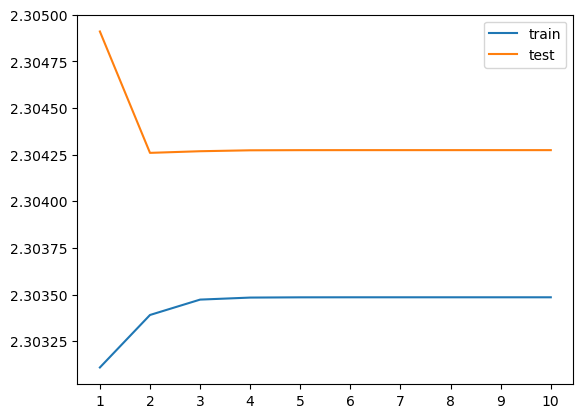

In [29]:
plt.plot(list(range(1, dnn.epoch+1)), dnn.loss_train, label='train')
plt.plot(list(range(1, dnn.epoch+1)), dnn.loss_val, label='test')
plt.xticks(list(range(1, dnn.epoch+1)))
plt.legend()
plt.show()

### **微調整**

学習率(lr) 0.005 → 0.003

sigma 0.02 → 0.01

### **データ数**

train 4000 → 1000

test 2000 → 500

In [23]:
# 微調整など変更後
DNN = ScratchDeepNeuralNetrowkClassifier(batch_size=20,n_features=784,n_nodes1 =400,n_nodes2 = 200,n_output =10,lr =0.003,epoch=10,sigma=0.01,optimizer=SGD, initializer=HeInitializer,activater=ReLU,output_activater=Softmax,verbose=True) 

DNN.fit(x_train[:1000], y_train_one_hot[:1000], x_val[:500], y_test_one_hot[:500])

epoch:0 train_loss:2.378579
epoch:1 train_loss:2.338211
epoch:2 train_loss:2.320816
epoch:3 train_loss:2.313056
epoch:4 train_loss:2.309426
epoch:5 train_loss:2.307628
epoch:6 train_loss:2.306668
epoch:7 train_loss:2.306122
epoch:8 train_loss:2.305801
epoch:9 train_loss:2.305606


In [209]:
PRED = dnn.predict(x_val)
accuracy_score(y_val, PRED)

0.10025

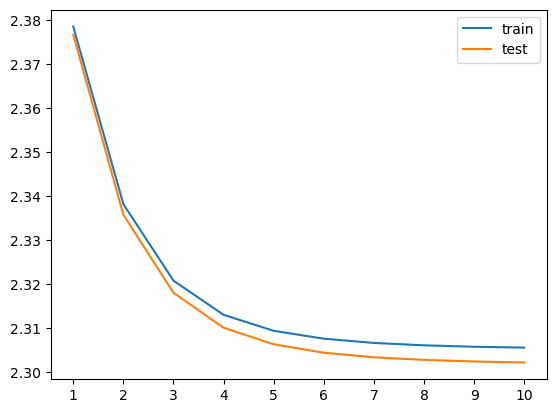

In [24]:
plt.plot(list(range(1, DNN.epoch+1)), DNN.loss_train, label='train')
plt.plot(list(range(1, DNN.epoch+1)), DNN.loss_val, label='test')
plt.xticks(list(range(1, DNN.epoch+1)))
plt.legend()
plt.show()

In [ ]:
# Trainロスが下がった